In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your integrated dataset
data = pd.read_csv('merged_data.csv')

# Feature Engineering
data['hour'] = pd.to_datetime(data['DateTime']).dt.hour
data['day_of_week'] = pd.to_datetime(data['DateTime']).dt.dayofweek
data['month'] = pd.to_datetime(data['DateTime']).dt.month
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

# Lag Features
data['lag_1'] = data['Vehicles'].shift(1)
data['lag_2'] = data['Vehicles'].shift(2)
data['lag_3'] = data['Vehicles'].shift(3)
data.dropna(inplace=True)

# Define features and target variable
features = ['hour', 'day_of_week', 'month', 'is_weekend', 'lag_1', 'lag_2', 'lag_3', 
            'temperature', 'precipitation', 'humidity', 'windspeed']
X = data[features]
y = data['Vehicles']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Time-based split
split_date = '2017-01-01'
train = data[data['DateTime'] < split_date]
test = data[data['DateTime'] >= split_date]

X_train = train[features]
y_train = train['Vehicles']
X_test = test[features]
y_test = test['Vehicles']


C:\Users\Madhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Madhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Madhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Madhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Madhu\anaconda3\lib\site-

Mean Squared Error (MSE): 988.2871831271419


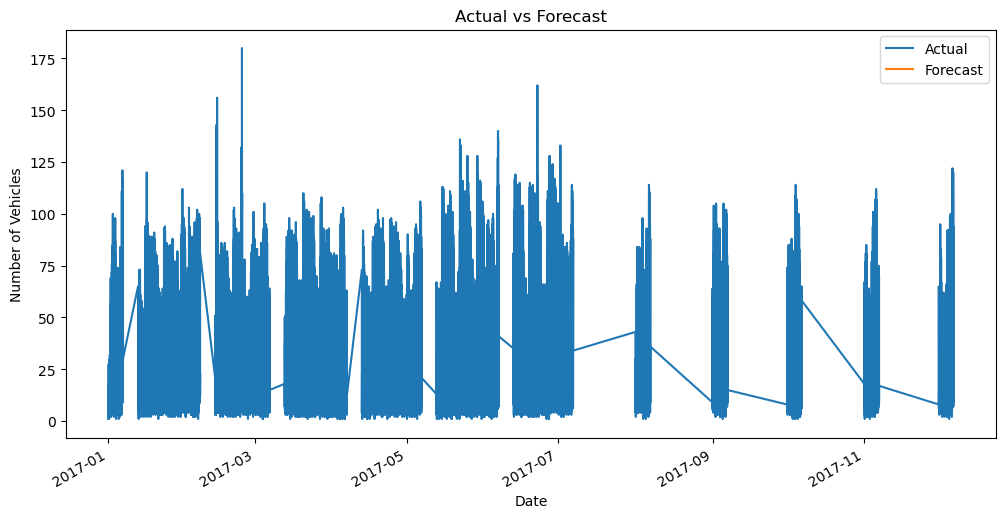

In [2]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming 'data' is your dataframe and 'split_date' is defined
# Example split_date
split_date = '2017-01-01'

# Prepare the series for ARIMA
traffic_series = data.set_index('DateTime')['Vehicles']

# Ensure 'datetime' is in datetime format
traffic_series.index = pd.to_datetime(traffic_series.index)

# Check if split_date is in correct format
try:
    split_date = pd.to_datetime(split_date)
except Exception as e:
    print(f"Error converting split_date: {e}")

# Check if split_date exists in the index
if split_date not in traffic_series.index:
    print(f"split_date {split_date} not found in the index.")
else:
    # Split the series
    train_series = traffic_series[traffic_series.index < split_date]
    test_series = traffic_series[traffic_series.index >= split_date]

    # Train ARIMA
    model_arima = ARIMA(train_series, order=(5, 1, 0))
    model_arima_fit = model_arima.fit()

    # Forecast
    forecast = model_arima_fit.forecast(steps=len(test_series))

    # Create a DataFrame to hold the test series and forecast
    results = pd.DataFrame({'Actual': test_series, 'Forecast': forecast}, index=test_series.index)

    # Evaluate
    mse = mean_squared_error(test_series, forecast)
    print(f'Mean Squared Error (MSE): {mse}')

    # Plot the results
    results.plot(title='Actual vs Forecast', figsize=(12, 6))
    plt.xlabel('Date')
    plt.ylabel('Number of Vehicles')
    plt.show()


In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# Prepare the sequence data for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X_seq, y_seq = create_sequences(traffic_series.values, seq_length)

# Split into training and test sets
split_idx = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

# Define LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Train LSTM
model_lstm.fit(X_train_seq, y_train_seq, epochs=50, verbose=1)

# Forecast
predicted = model_lstm.predict(X_test_seq)

# Evaluate
print(f'MSE: {np.mean((y_test_seq - predicted.flatten())**2)}')


Epoch 1/50


C:\Users\Madhu\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 53.5182
Epoch 2/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 21.4777
Epoch 3/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 19.5292
Epoch 4/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 18.1628
Epoch 5/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 18.4015
Epoch 6/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 19.1998
Epoch 7/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 17.0549
Epoch 8/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 18.2159
Epoch 9/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 19.0140
Epoch 10/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 18.2234
Epoch 11/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 18.0977
Epoch 12/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 17.1064
Epoch 13/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 17.1186
Epoch 14/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 18.4870
Epoch 15/50
1203/1203 ━━━━

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Train Gradient Boosting Regressor
model_gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gbr.fit(X_train, y_train)

# Predict
y_pred = model_gbr.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')


MSE: 22.334734190440493


In [5]:
from sklearn.model_selection import GridSearchCV

# Example with Gradient Boosting Regressor
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')


Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150}


In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming test_series is a pandas Series
# Print the Series to inspect the data
print("test_series:")
print(test_series.head())

# Check if 'Vehicles' and 'forecast' are present in the Series index (or name)
if 'Vehicles' in test_series.index and 'forecast' in test_series.index:
    # Evaluate ARIMA model (with error handling)
    try:
        mae_arima = mean_absolute_error(test_series['Vehicles'], test_series['forecast'])
        rmse_arima = np.sqrt(mean_squared_error(test_series['Vehicles'], test_series['forecast']))
        r2_arima = r2_score(test_series['Vehicles'], test_series['forecast'])

        print(f'ARIMA Model Evaluation:')
        print(f'MAE: {mae_arima}')
        print(f'RMSE: {rmse_arima}')
        print(f'R-squared: {r2_arima}')
    except KeyError as e:
        print(f"KeyError: {e}. Please check if the columns 'Vehicles' and 'forecast' exist in test_series.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print("The required columns 'Vehicles' and 'forecast' are not present in test_series.")


test_series:
DateTime
2017-01-01 00:00:00    27
2017-01-01 01:00:00    23
2017-01-01 02:00:00    17
2017-01-01 03:00:00    16
2017-01-01 04:00:00    16
Name: Vehicles, dtype: int64
The required columns 'Vehicles' and 'forecast' are not present in test_series.


In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Sample test_series with actual values
test_series = pd.Series(
    [27, 23, 17, 16, 16],
    index=pd.date_range(start='2017-01-01 00:00:00', periods=5, freq='H'),
    name='Vehicles'
)

# Sample forecast_series with forecasted values
forecast_series = pd.Series(
    [26, 24, 18, 15, 17],
    index=pd.date_range(start='2017-01-01 00:00:00', periods=5, freq='H'),
    name='forecast'
)

# Ensure both Series have unique indices
test_series = test_series[~test_series.index.duplicated(keep='first')]
forecast_series = forecast_series[~forecast_series.index.duplicated(keep='first')]

# Align the Series to have the same index
combined_df = pd.DataFrame({'Vehicles': test_series, 'forecast': forecast_series})

# Print the combined DataFrame to inspect
print("Combined DataFrame:")
print(combined_df.head())

# Evaluate ARIMA model
try:
    mae_arima = mean_absolute_error(combined_df['Vehicles'], combined_df['forecast'])
    rmse_arima = np.sqrt(mean_squared_error(combined_df['Vehicles'], combined_df['forecast']))
    r2_arima = r2_score(combined_df['Vehicles'], combined_df['forecast'])

    print(f'ARIMA Model Evaluation:')
    print(f'MAE: {mae_arima}')
    print(f'RMSE: {rmse_arima}')
    print(f'R-squared: {r2_arima}')
except KeyError as e:
    print(f"KeyError: {e}. Please check if the columns 'Vehicles' and 'forecast' exist in the combined DataFrame.")
except Exception as e:
    print(f"An error occurred: {e}")


Combined DataFrame:
                     Vehicles  forecast
2017-01-01 00:00:00        27        26
2017-01-01 01:00:00        23        24
2017-01-01 02:00:00        17        18
2017-01-01 03:00:00        16        15
2017-01-01 04:00:00        16        17
ARIMA Model Evaluation:
MAE: 1.0
RMSE: 1.0
R-squared: 0.9493927125506073


In [8]:
# Evaluate LSTM model
mae_lstm = mean_absolute_error(y_test_seq, predicted.flatten())
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, predicted.flatten()))
r2_lstm = r2_score(y_test_seq, predicted.flatten())

print(f'LSTM Model Evaluation:')
print(f'MAE: {mae_lstm}')
print(f'RMSE: {rmse_lstm}')
print(f'R-squared: {r2_lstm}')


LSTM Model Evaluation:
MAE: 2.849023218289702
RMSE: 4.962889864769339
R-squared: 0.7521196865095383


In [9]:
# Evaluate Gradient Boosting Trees model
mae_gbr = mean_absolute_error(y_test, y_pred)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_gbr = r2_score(y_test, y_pred)

print(f'Gradient Boosting Trees Model Evaluation:')
print(f'MAE: {mae_gbr}')
print(f'RMSE: {rmse_gbr}')
print(f'R-squared: {r2_gbr}')


Gradient Boosting Trees Model Evaluation:
MAE: 2.861371507190193
RMSE: 4.725963837191361
R-squared: 0.9511147216291798


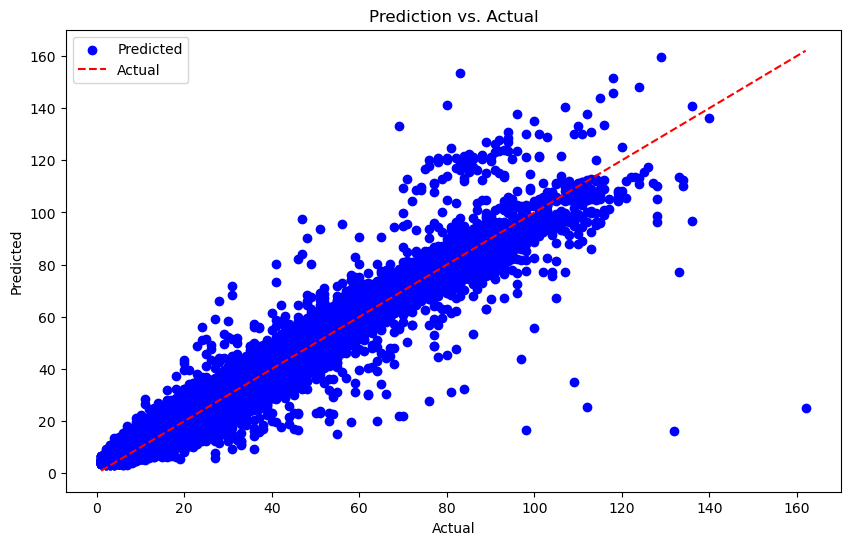

In [10]:
import matplotlib.pyplot as plt

# Example for Gradient Boosting Trees
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction vs. Actual')
plt.legend()
plt.show()


In [11]:
from sklearn.model_selection import KFold, cross_val_score

# Example with Gradient Boosting Trees
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = GradientBoostingRegressor(n_estimators=100, random_state=42)

scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
rmse_scores = np.sqrt(-scores)

print(f'Cross-Validation RMSE: {rmse_scores}')
print(f'Mean RMSE: {np.mean(rmse_scores)}')


Cross-Validation RMSE: [3.97013626 4.08790725 3.9980726  4.35044697 4.15985215]
Mean RMSE: 4.11328304532344


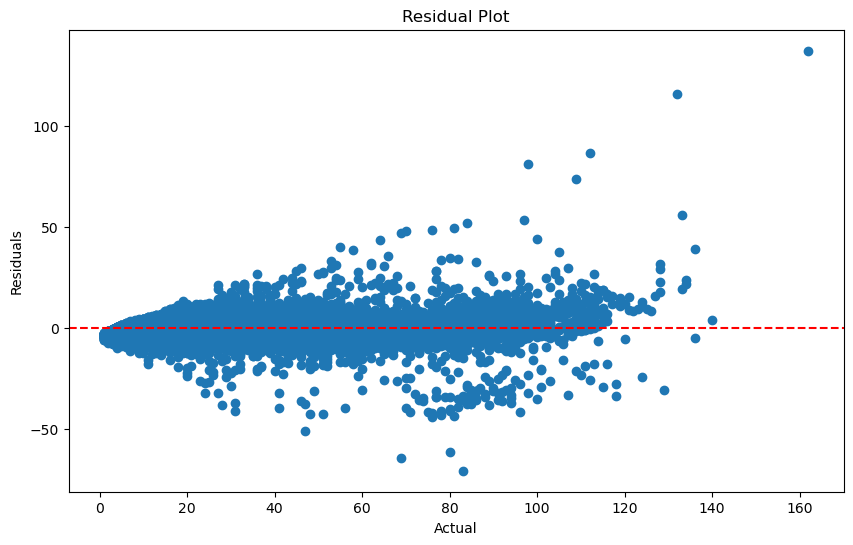

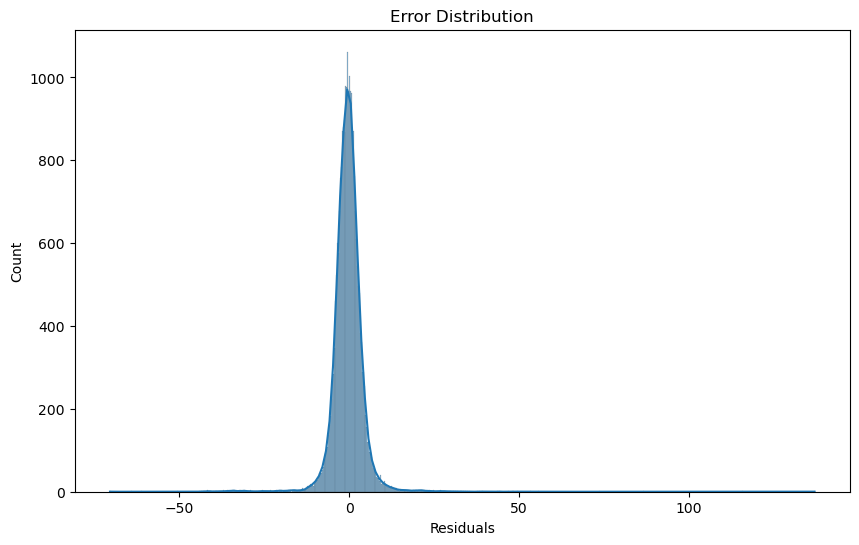

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Error distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Error Distribution')
plt.show()


In [13]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [14]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} - MAE: {mean_absolute_error(y_test, y_pred)}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}, R2: {r2_score(y_test, y_pred)}')


Linear Regression - MAE: 3.36798848677185, RMSE: 5.061203554276778, R2: 0.9439333105727143
Random Forest - MAE: 2.8753415921754875, RMSE: 4.520819309169446, R2: 0.9552666314709226
Gradient Boosting - MAE: 2.861371507190193, RMSE: 4.725963837191361, R2: 0.9511147216291798
XGBoost - MAE: 2.84047170927906, RMSE: 4.4676942699393045, R2: 0.9563117954820798


In [15]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f'Best Model - MAE: {mean_absolute_error(y_test, y_pred)}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}, R2: {r2_score(y_test, y_pred)}')


Best Model - MAE: 2.825374291357231, RMSE: 4.459987582359778, R2: 0.956462388127738


In [16]:
import joblib
joblib.dump(model, 'trained_model.pkl')

['trained_model.pkl']